# Anomaly detection with Keras, TensorFlow, and Deep Learning

**Anomalies are defined as events that deviate from the standard, happen rarely, and don’t follow the rest of the “pattern.”**

Examples of anomalies include:

- Large dips and spikes in the stock market due to world events
- Defective items in a factory/on a conveyor belt
- Contaminated samples in a lab

**The encoder accepts the input data and compresses it into the latent-space representation.** 

**The decoder then attempts to reconstruct the input data from the latent space.**

When trained in an end-to-end fashion, the hidden layers of the network learn filters that are robust and even capable of denoising the input data.

However, what makes autoencoders so special from an anomaly detection perspective is the reconstruction loss. When we train an autoencoder, we typically measure the mean-squared-error (MSE) between:

- The input image
- The reconstructed image from the autoencoder

>> The lower the loss, the better a job the autoencoder is doing at reconstructing the image.

In [2]:
from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import cv2

### Create an unsupervised dataset

In [3]:
def build_unsupervised_dataset(data, labels, validLabel=1, anomalyLabel=3, contam=0.01, seed=42):

    #grab the indexes of the label we want. Do the same fot the 'anomalies'
    validIdxs = np.where(labels == validLabel)[0]
    anomalyIdxs = np.where(labels == anomalyLabel)[0]

    #Randomly shuffle the indexes
    random.shuffle(validIdxs)
    random.shuffle(anomalyIdxs)

    #compute the total number of anomaly data points
    i = int(len(validIdxs)*contam)
    anomalyIdxs = anomalyIdxs[:i]

    #Index the valid images and the anomaly ones
    validImages = data[validIdxs]
    anomalyImages = data[anomalyIdxs]

    #Stack both the valid and anomalies images to forn a single data matrix
    images = np.vstack([validImages, anomalyImages])
    np.random.seed(seed)
    np.random.shuffle(images)

    return images

### Visualization function

In [4]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

### Get the data, process it and train the model

In [5]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

In [6]:
#make the anomaly dataset
images = build_unsupervised_dataset(trainX, trainY, validLabel=1,
	anomalyLabel=3, contam=0.01)

In [7]:
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

In [8]:
(trainX, testX) = train_test_split(images, test_size=0.2,
	random_state=42)

In [9]:
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)

In [10]:
#Using decay is beneficial for this task
autoencoder.compile(loss="mse", optimizer=Adam(learning_rate=1e-3, decay=1e-3/20))

In [11]:
H = autoencoder.fit( trainX, trainX, validation_data=(testX, testX), epochs=20,
	batch_size=32)

Epoch 1/20
171/171 [==============================] - 3s 8ms/step - loss: 0.0420 - val_loss: 0.0438
Epoch 2/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0295
Epoch 3/20
171/171 [==============================] - 1s 7ms/step - loss: 0.0044 - val_loss: 0.0101
Epoch 4/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/20
171/171 [==============================] - 1s 7ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 10/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0023

### Predictionnd outputs

In [12]:
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite("/media/juan/juan1/pyimage_univ/Autoencoders/anomaly_detection/output/recon_vis.png", vis)

43/43 [==============================] - 0s 3ms/step


True

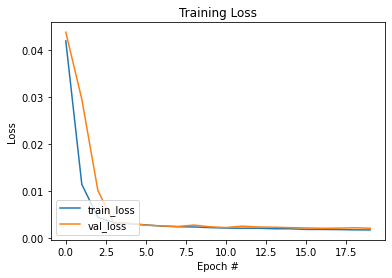

In [14]:
N = np.arange(0, 20)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [ ]:
#Save the anomaly dataset
f = open(".../anomalies.pickle", "wb")
f.write(pickle.dumps(images))
f.close()

In [ ]:
#Save the model
autoencoder.save("/anomaly_det/", save_format="h5")